# Project Title:
***Customer Segmentation (Week 4 Project)***  
**Presented By-**
*Ayush Singh*

# Domain :
***E-Commerce***

# Description:
***This notebook follows the Week 4 steps-***  
*1. Collect and prepare data*  
*2. Do simple analysis (EDA)*  
*3. Use PCA to reduce data*  
*4. Use K-Means to make groups (clusters)*  
*5. Check best number of groups (Elbow & Silhouette)*  
*6. Show the groups in a graph*  
*7. Give simple insights*  

## Step 1: Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
sns.set(style="whitegrid")

## Step 2: Load and clean data

In [5]:
# Load Data
df = pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.shape

(541909, 8)

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
# Dropping rows where CustomerID is missing
df = df.dropna(subset=['CustomerID'])

In [9]:
# Removing cancelled invoices (those starting with "C")
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [10]:
# Keeping only positive Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [11]:
# Adding TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [12]:
print("Data shape after cleaning:", df.shape)
df.head()

Data shape after cleaning: (397884, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Step 3: Creating RFM table  
- R = Recency (how many days since last purchase)
- F = Frequency (how many orders)
- M = Monetary (how much money spent)

In [13]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [14]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

In [15]:
rfm = rfm.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalPrice':'Monetary'})

In [16]:
print("RFM shape:", rfm.shape)
rfm.head()

RFM shape: (4338, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


 ## Step 4: Explore data (EDA)

In [17]:
print(rfm[['Recency','Frequency','Monetary']].describe())

           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    2054.266460
std     100.014169     7.697998    8989.230441
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     307.415000
50%      51.000000     2.000000     674.485000
75%     142.000000     5.000000    1661.740000
max     374.000000   209.000000  280206.020000


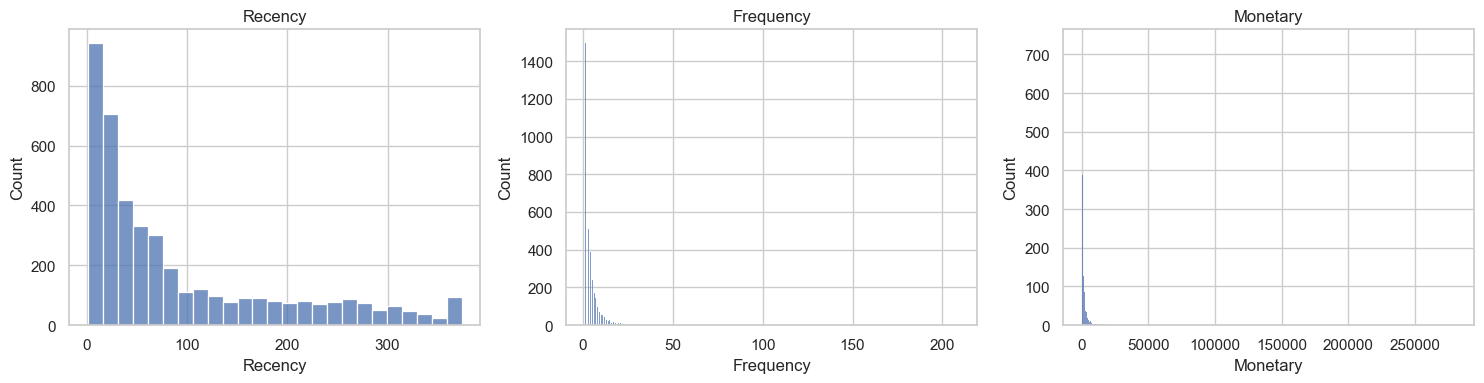

In [20]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
for i, col in enumerate(['Recency','Frequency','Monetary']):
    sns.histplot(rfm[col], ax=axes[i], kde=False)
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

## Step 5: Scale and use PCA

In [22]:
scaler = StandardScaler()
x_scale = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

In [24]:
pca = PCA(n_components=2,random_state=42)
x_pca = pca.fit_transform(x_scale)
print("PCA explained variance:", pca.explained_variance_ratio_)

PCA explained variance: [0.55502102 0.30249315]


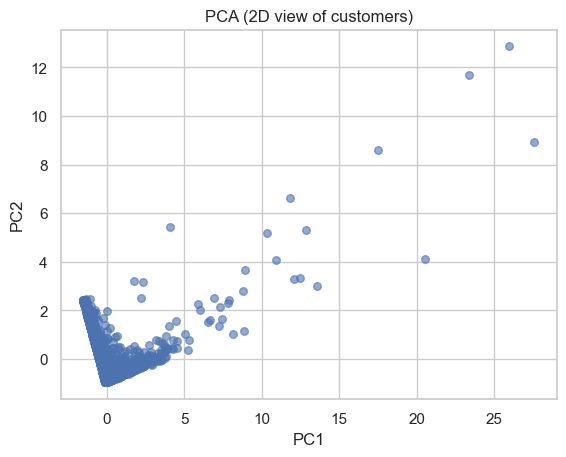

In [27]:
plt.scatter(x_pca[:,0], x_pca[:,1], s=30, alpha=0.6)
plt.title("PCA (2D view of customers)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## Step 6: Finding best number of groups (clusters)

In [28]:
wcss = []
sil_scores = []
K_range = range(2, 11)

In [30]:
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(x_scale)
    wcss.append(km.inertia_)
    sil_scores.append(silhouette_score(x_scale, labels))
    print(f"k={k}, WCSS={km.inertia_:.0f}, Silhouette={sil_scores[-1]:.3f}")


k=2, WCSS=9013, Silhouette=0.896
k=3, WCSS=5439, Silhouette=0.594
k=4, WCSS=4092, Silhouette=0.616
k=5, WCSS=3118, Silhouette=0.617
k=6, WCSS=2473, Silhouette=0.596
k=7, WCSS=2022, Silhouette=0.516
k=8, WCSS=1742, Silhouette=0.517
k=9, WCSS=1446, Silhouette=0.478
k=10, WCSS=1303, Silhouette=0.427


Text(0, 0.5, 'WCSS')

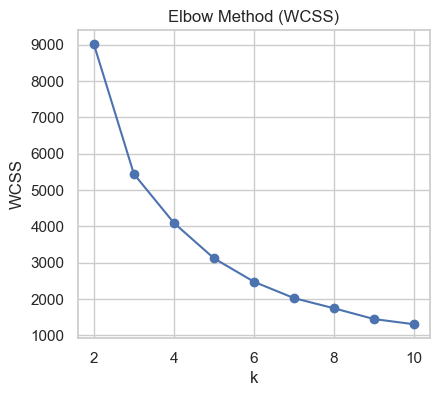

In [31]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_range, wcss, marker='o')
plt.title("Elbow Method (WCSS)")
plt.xlabel("k"); plt.ylabel("WCSS")

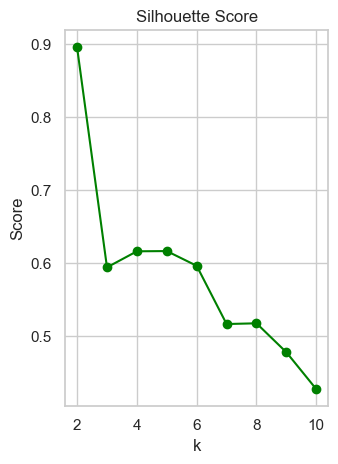

In [32]:
plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("k"); plt.ylabel("Score")
plt.tight_layout()
plt.show()

## Step 7: Choosing k and make final groups

In [33]:
best_k = list(K_range)[np.argmax(sil_scores)]
print("Best k =", best_k)

Best k = 2


In [35]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(x_scale)

In [36]:
rfm['Cluster'].value_counts()

Cluster
0    4312
1      26
Name: count, dtype: int64

## Step 8: Showing groups on graph

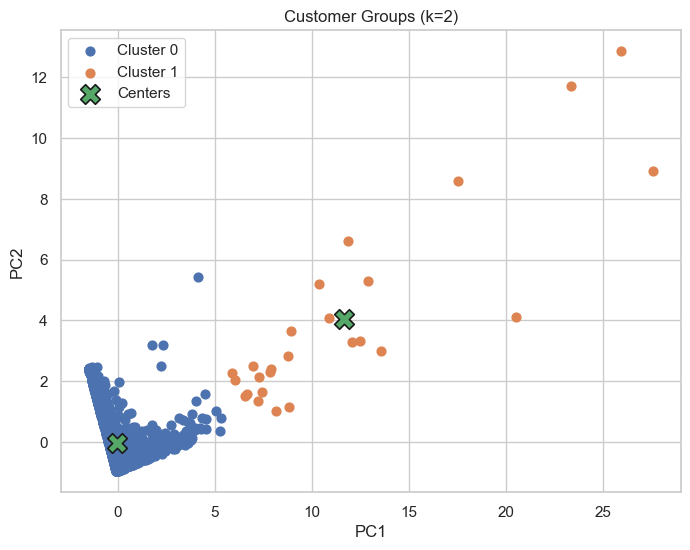

In [40]:
plt.figure(figsize=(8,6))
for c in range(best_k):
    mask = (rfm['Cluster'] == c)
    plt.scatter(x_pca[mask,0], x_pca[mask,1], s=40, label=f"Cluster {c}")
centers = kmeans.cluster_centers_
centers_pca = pca.transform(centers)
plt.scatter(centers_pca[:,0], centers_pca[:,1], s=200, marker='X', edgecolor='k', linewidth=1.2, label='Centers')
plt.title(f"Customer Groups (k={best_k})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.show()